### Code to change .tsf file into dataframe

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import numpy as np

In [31]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd


# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


# Example of usage
# loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

# print(loaded_data)
# print(frequency)
# print(forecast_horizon)
# print(contain_missing_values)
# print(contain_equal_length)

## The data saved as dataframe

In [32]:
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("/Users\shadi\Downloads\ADS2002 Sem 2\Project\phase_1_data.tsf")

In [33]:
loaded_data

,series_name,start_timestamp,series_value
0,Building0,2016-07-03 21:30:00,"[283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606..."
1,Building1,2019-01-09 23:15:00,"[8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,..."
2,Building3,2016-03-01 04:15:00,"[1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293...."
3,Building4,2019-07-03 04:45:00,"[2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ..."
4,Building5,2019-07-25 23:00:00,"[30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33...."
5,Building6,2019-07-25 01:45:00,"[36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35...."
6,Solar0,2020-04-25 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,Solar1,2018-12-31 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,Solar2,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Solar3,2019-06-05 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Need to change the dataframe into more usable format

In [34]:
# Change the index to be time and date 
# Have the buildings and solar panels be the columns
# Merge with the weather data
# Merge with the energy price data

In [35]:
# Going through each row to create a new dataframe and manipulating it
df_building0 = pd.DataFrame(pd.date_range(start = '2016-07-03 21:30:00', freq='15T', periods=len(loaded_data.iloc[0, 2])))
df_building0.columns = ['Datetime']
df_building0['Building0'] = loaded_data.iloc[0, 2]
df_building0 = df_building0.set_index('Datetime')

df_building1 = pd.DataFrame(pd.date_range(start = '2019-01-09 23:15:00', freq='15T', periods=len(loaded_data.iloc[1, 2])))
df_building1.columns = ['Datetime']
df_building1['Building1'] = loaded_data.iloc[1, 2]
df_building1 = df_building1.set_index('Datetime')

df_building3 = pd.DataFrame(pd.date_range(start = '2016-03-01 04:15:00', freq='15T', periods=len(loaded_data.iloc[2, 2])))
df_building3.columns = ['Datetime']
df_building3['Building3'] = loaded_data.iloc[2, 2]
df_building3 = df_building3.set_index('Datetime')

df_building4 = pd.DataFrame(pd.date_range(start = '2019-07-03 04:45:00', freq='15T', periods=len(loaded_data.iloc[3, 2])))
df_building4.columns = ['Datetime']
df_building4['Building4'] = loaded_data.iloc[3, 2]
df_building4 = df_building4.set_index('Datetime')

df_building5 = pd.DataFrame(pd.date_range(start = '2019-07-25 23:00:00', freq='15T', periods=len(loaded_data.iloc[4, 2])))
df_building5.columns = ['Datetime']
df_building5['Building5'] = loaded_data.iloc[4, 2]
df_building5 = df_building5.set_index('Datetime')

df_building6 = pd.DataFrame(pd.date_range(start = '2019-07-25 01:45:00', freq='15T', periods=len(loaded_data.iloc[5, 2])))
df_building6.columns = ['Datetime']
df_building6['Building6'] = loaded_data.iloc[5, 2]
df_building6 = df_building6.set_index('Datetime')

df_solar0 = pd.DataFrame(pd.date_range(start = '2020-04-25 14:00:00', freq='15T', periods=len(loaded_data.iloc[6, 2])))
df_solar0.columns = ['Datetime']
df_solar0['solar0'] = loaded_data.iloc[6, 2]
df_solar0 = df_solar0.set_index('Datetime')

df_solar1 = pd.DataFrame(pd.date_range(start = '2018-12-31 13:00:00', freq='15T', periods=len(loaded_data.iloc[7, 2])))
df_solar1.columns = ['Datetime']
df_solar1['solar1'] = loaded_data.iloc[7, 2]
df_solar1 = df_solar1.set_index('Datetime')

df_solar2 = pd.DataFrame(pd.date_range(start = '2019-06-05 14:00:00', freq='15T', periods=len(loaded_data.iloc[8, 2])))
df_solar2.columns = ['Datetime']
df_solar2['solar2'] = loaded_data.iloc[8, 2]
df_solar2 = df_solar2.set_index('Datetime')

df_solar3 = pd.DataFrame(pd.date_range(start = '2019-06-05 14:00:00', freq='15T', periods=len(loaded_data.iloc[9, 2])))
df_solar3.columns = ['Datetime']
df_solar3['solar3'] = loaded_data.iloc[9, 2]
df_solar3 = df_solar3.set_index('Datetime')

df_solar4 = pd.DataFrame(pd.date_range(start = '2019-06-05 14:00:00', freq='15T', periods=len(loaded_data.iloc[10, 2])))
df_solar4.columns = ['Datetime']
df_solar4['solar4'] = loaded_data.iloc[10, 2]
df_solar4 = df_solar4.set_index('Datetime')

df_solar5 = pd.DataFrame(pd.date_range(start = '2019-01-15 13:00:00', freq='15T', periods=len(loaded_data.iloc[11, 2])))
df_solar5.columns = ['Datetime']
df_solar5['solar5'] = loaded_data.iloc[11, 2]
df_solar5 = df_solar5.set_index('Datetime')

### Checking the individual dataframes


In [36]:
# Building4 has Nan but are not recognised as they are strings
df_building4

,Building4
Datetime,
2019-07-03 04:45:00,2
2019-07-03 05:00:00,NaN
2019-07-03 05:15:00,1
2019-07-03 05:30:00,2
2019-07-03 05:45:00,NaN
...,...
2020-09-30 22:45:00,NaN
2020-09-30 23:00:00,1
2020-09-30 23:15:00,NaN


In [37]:
type(df_building4.iloc[1,0])

str

In [38]:
df_building4["Building4"].isnull().values.any()

False

In [39]:
df_building4 = df_building4.replace('NaN', np.nan)

In [40]:
type(df_building4.iloc[1,0])

numpy.float64

In [41]:
df_building4["Building4"].isnull().values.any()

True

In [42]:
# Checking if others have Nan's 
def nan_string_convert(dataframe):
    new_dataframe = dataframe.replace('NaN', np.nan)
    return new_dataframe

df_building0 = nan_string_convert(df_building0)
df_building1 = nan_string_convert(df_building1)
df_building3 = nan_string_convert(df_building3)
df_building4 = nan_string_convert(df_building4)
df_building5 = nan_string_convert(df_building5)
df_building6 = nan_string_convert(df_building6)
df_solar0 = nan_string_convert(df_solar0)
df_solar1 = nan_string_convert(df_solar1)
df_solar2 = nan_string_convert(df_solar2)
df_solar3 = nan_string_convert(df_solar3)
df_solar4 = nan_string_convert(df_solar4)
df_solar5 = nan_string_convert(df_solar5)

print(df_building0.isnull().values.any())
print(df_building1.isnull().values.any())
print(df_building3.isnull().values.any())
print(df_building4.isnull().values.any())
print(df_building5.isnull().values.any())
print(df_building6.isnull().values.any())
print(df_solar0.isnull().values.any())
print(df_solar1.isnull().values.any())
print(df_solar2.isnull().values.any())
print(df_solar3.isnull().values.any())
print(df_solar4.isnull().values.any())
print(df_solar5.isnull().values.any())


True
True
True
True
True
True
False
False
False
False
False
False


#### Observations
All the buildings have missing values

### Merging all the individual dataframes together

In [43]:
df_1 = pd.merge(df_building0, df_building1, left_index=True, right_index = True, how = 'outer')
df_2 = pd.merge(df_1, df_building3, left_index=True, right_index=True, how = 'outer')
df_3 = pd.merge(df_2, df_building4, left_index=True, right_index=True, how = 'outer')
df_4 = pd.merge(df_3, df_building5, left_index=True, right_index=True, how = 'outer')
df_5 = pd.merge(df_4, df_building6, left_index=True, right_index=True, how = 'outer')
df_6 = pd.merge(df_5, df_solar0, left_index=True, right_index=True, how = 'outer')
df_7 = pd.merge(df_6, df_solar1, left_index=True, right_index=True, how = 'outer')
df_8 = pd.merge(df_7, df_solar2, left_index=True, right_index=True, how = 'outer')
df_9 = pd.merge(df_8, df_solar3, left_index=True, right_index=True, how = 'outer')
df_10 = pd.merge(df_9, df_solar4, left_index=True, right_index=True, how = 'outer')
finished_data = pd.merge(df_10, df_solar5, left_index=True, right_index=True, how = 'outer')
finished_data

,Building0,Building1,Building3,Building4,Building5,Building6,solar0,solar1,solar2,solar3,solar4,solar5
Datetime,,,,,,,,,,,,
2016-03-01 04:15:00,NaN,NaN,1321.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 04:30:00,NaN,NaN,1321.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 04:45:00,NaN,NaN,1321.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 05:00:00,NaN,NaN,1321.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 05:15:00,NaN,NaN,1293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,96.9,14.4,389.0,NaN,NaN,35.6,29.67,6.68,6.34,5.49,4.55,25.28
2020-09-30 23:00:00,96.9,18.8,389.0,1.0,NaN,38.6,29.94,6.71,6.39,5.65,4.57,25.30
2020-09-30 23:15:00,37.4,4.5,415.0,NaN,NaN,38.6,34.02,8.13,7.71,6.83,5.32,28.62


In [44]:
finished_data = finished_data.apply(pd.to_numeric, errors = 'coerce')
finished_data.describe(include = 'all')

,Building0,Building1,Building3,Building4,Building5,Building6,solar0,solar1,solar2,solar3,solar4,solar5
count,101406.000000,60395.000000,160222.000000,26096.000000,11580.000000,39402.000000,15208.000000,61388.000000,46408.000000,46408.000000,46408.000000,59948.000000
mean,230.108545,11.374756,517.935702,1.327866,24.666062,30.705822,4.386435,1.937350,1.877698,1.358164,1.117320,3.890990
std,133.536120,7.910689,273.806102,0.530892,11.103474,5.593896,8.858768,3.434536,3.123851,2.213344,1.893412,8.745043
min,0.100000,1.500000,85.000000,1.000000,1.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,168.300000,5.700000,308.000000,1.000000,18.000000,26.600000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,214.850000,9.400000,392.000000,1.000000,21.000000,28.600000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,277.100000,14.500000,723.000000,2.000000,36.000000,35.000000,4.130000,2.410000,3.370000,1.720000,1.550000,0.970000
max,6781.500000,83.500000,8556.000000,5.000000,62.000000,102.200000,50.410000,13.040000,13.960000,11.040000,8.100000,40.430000


### Observations
Can see that Building 5 has the least number of observations. Building0 and Building 3 have the highest energy demand while Building4 is extremely low (could be an outlier). Each building will follow a different energy demand model / function. Solar0 and Solar5 generate around 2x more energy than the other solar panels. 

Looking at the average energy that each building requires, the average across buildings vary significantly as the average energy needed for building 4 is only 1 unit whereas buildings 0 and 3 require substantially more. Building 1 and building 5 also require minimal energy in order to power the energy on average. The solar power energy generated by each one seems to be relatively close, with only solar 0 and solar 5 generating around 2 times more than the others. 

In [45]:
(finished_data.values < 0).any()

False

In [46]:
df_building0.tail()

,Building0
Datetime,
2020-09-30 22:45:00,96.9
2020-09-30 23:00:00,96.9
2020-09-30 23:15:00,37.4
2020-09-30 23:30:00,37.4
2020-09-30 23:45:00,37.4


There are no negative values


### Solar power observations

Text(0.5, 1.0, 'Boxplot for solar panel activity')

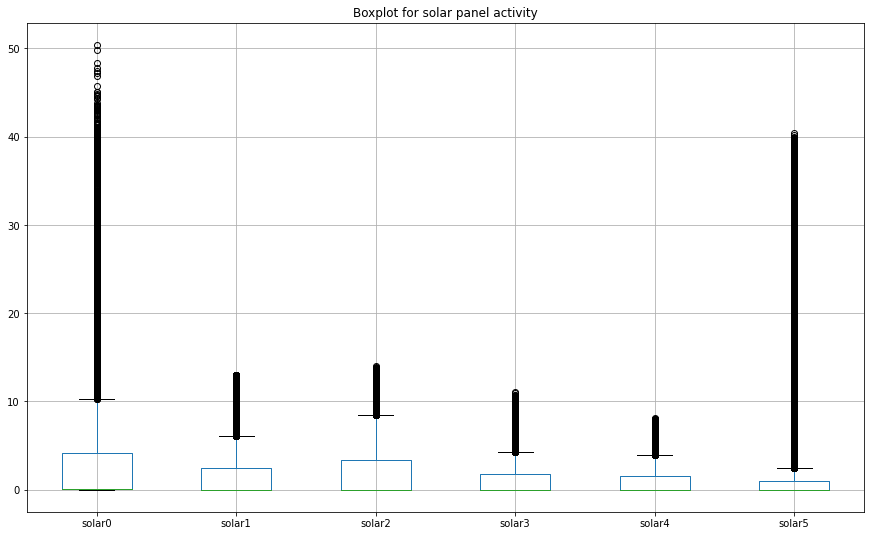

In [47]:
finished_data.loc[:, "solar0":"solar5"].boxplot(figsize = (15, 9));
plt.title('Boxplot for solar panel activity')

The median for each solar is 0 because majority of the observations would be 0 as the dataframe takes into account the night time. Solar0 and Solar5 tend to generate more energy in comparison.

In [48]:
# Filtering the solar dataset for only daytime
daytime_solar_data = finished_data.loc[:, "solar0":"solar5"].between_time("6:00", "18:00")
daytime_solar_data

,solar0,solar1,solar2,solar3,solar4,solar5
Datetime,,,,,,
2016-03-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 06:15:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 06:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 06:45:00,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-09-30 17:00:00,0.01,0.0,0.0,0.0,0.0,0.0
2020-09-30 17:15:00,0.01,0.0,0.0,0.0,0.0,0.0
2020-09-30 17:30:00,0.01,0.0,0.0,0.0,0.0,0.0


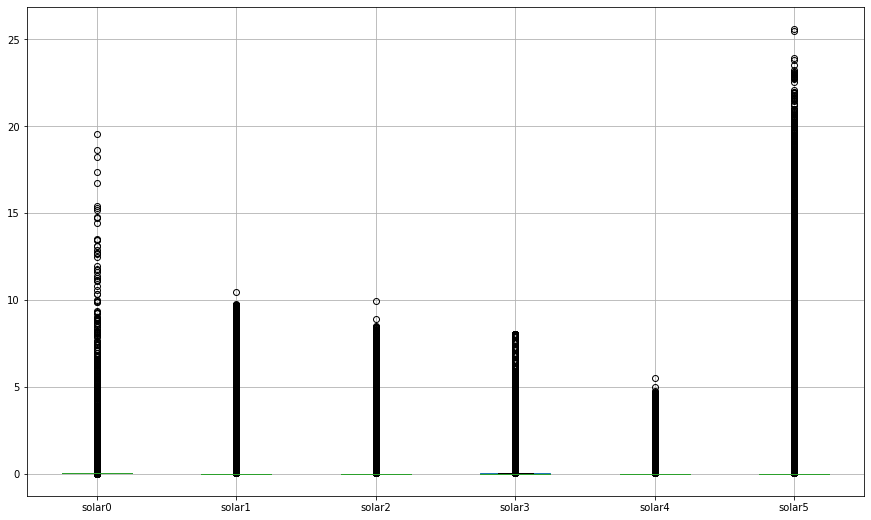

In [49]:
daytime_solar_data.boxplot(figsize = (15, 9));

Seeing the solar data during the days shows that 50% or more observations are still 0, even during the day. So need to explore the times the solar farm is actually used. The other times that solar power is actually being produced are seen as outliers, hence why the black solid lines of outliers

In [50]:
solar0_only = finished_data['solar0']
solar0_online = solar0_only.loc[solar0_only > 4]
pd.DataFrame(solar0_online).tail(n=30)

,solar0
Datetime,
2020-09-30 02:30:00,16.55
2020-09-30 02:45:00,19.25
2020-09-30 03:00:00,21.96
2020-09-30 03:15:00,24.58
2020-09-30 03:30:00,28.64
2020-09-30 03:45:00,25.33
2020-09-30 04:00:00,22.30
2020-09-30 04:15:00,17.54
2020-09-30 04:30:00,14.26


Looking at the times when Solar0 is producing more than the mean energy it is producing, it is generally producing the energy during midnight to 5am?????

Text(0.5, 1.0, 'Density plot for solar panels')

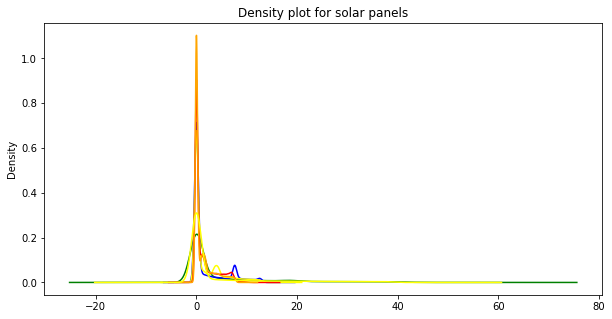

In [51]:
# Graphing the density for the solar panels
plt.figure(figsize = (10,5))
finished_data.solar0.plot.density(color='green');
finished_data.solar1.plot.density(color='blue');
finished_data.solar2.plot.density(color='yellow');
finished_data.solar3.plot.density(color='red');
finished_data.solar4.plot.density(color='orange');
finished_data.solar5.plot.density(color='yellow');
plt.title('Density plot for solar panels')


We can see that majority the solar power produced is 0 through the huge spike at the 0 mark. This is a problem as this means that the solar power data lacks a lot of information. We have to find out why majority of values is 0 and use the values when solar IS being produced in order to make a model

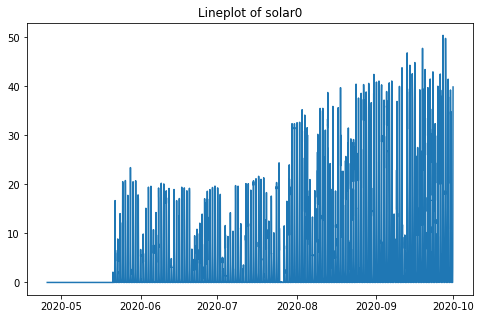

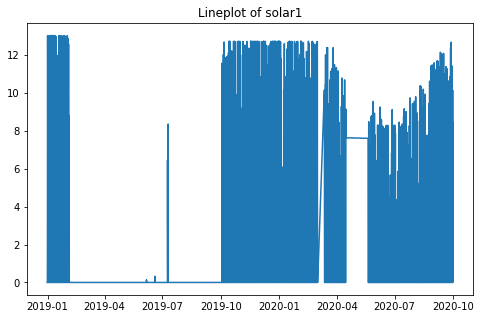

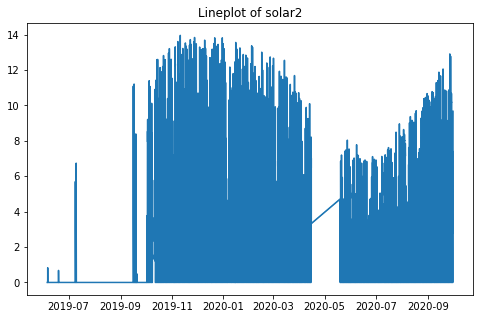

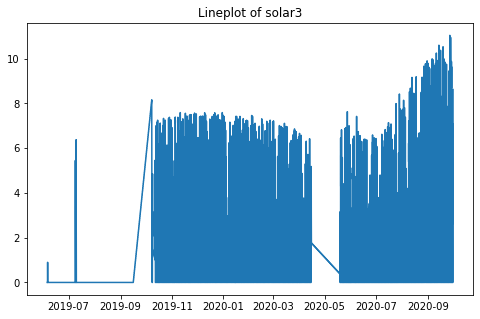

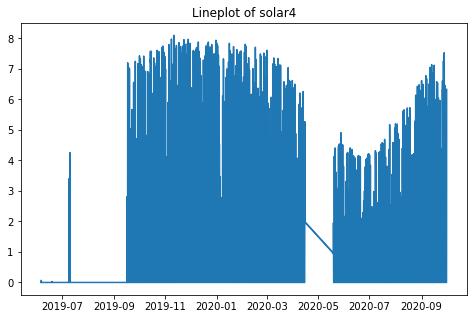

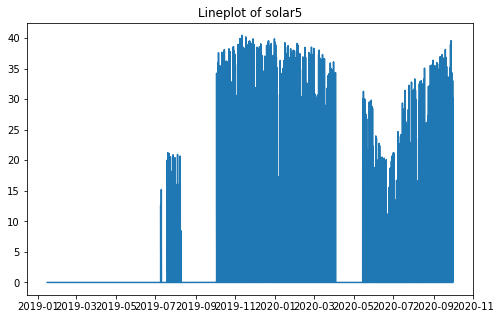

In [52]:
def lineplot(data):
    req_data_set = pd.DataFrame(finished_data[data].dropna())
    plt.figure(figsize=(8, 5))
    var_name = plt.plot(req_data_set.index, req_data_set)
    plt.title('Lineplot of ' + data)
    return var_name

solar0_plot = lineplot('solar0')
solar1_plot = lineplot('solar1')
solar2_plot = lineplot('solar2')
solar3_plot = lineplot('solar3')
solar4_plot = lineplot('solar4')
solar5_plot = lineplot('solar5')

<AxesSubplot:xlabel='Datetime'>

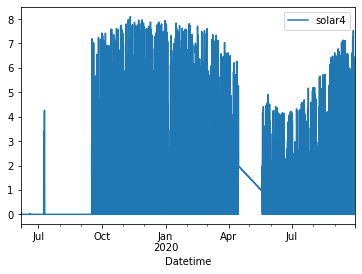

In [53]:
df_solar4.plot()

After graphing each solar, we can see that near the beginning of the solar panels observations, it's constantly 0. Then we get continous observations and around ~/4/2020 - ~/6_2020, we also see a gap of declining power supply except for solar0. If we include this in the model, this could definitly affect the model's accuracy as the solar power panels are essentially inactive at the earlier time periods.

<AxesSubplot:xlabel='Datetime'>

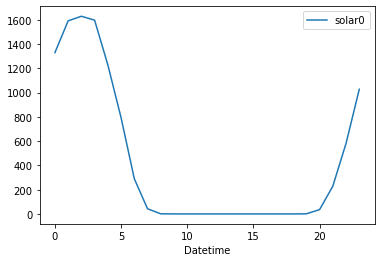

In [54]:
solar_data = finished_data.loc[:,"solar0":"solar5"]
solar_data = solar_data.dropna()
solar_data["day"] = solar_data.index.day_name()
solar_data0 = solar_data[['solar0', 'day']] 
mon_solar_data0 = solar_data0.loc[solar_data0['day'] == 'Monday']
mon_solar_data0_fin = mon_solar_data0.groupby(mon_solar_data0.index.hour).sum()
mon_solar_data0_fin.plot()


### Building observations

Text(0.5, 1.0, 'Boxplot of energy consumption in buildings')

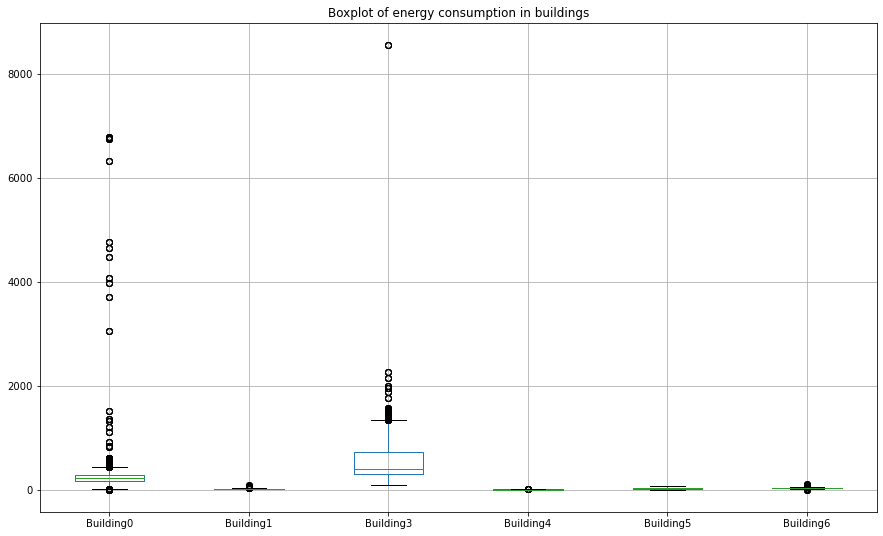

In [55]:
finished_data.loc[:, "Building0":"Building6"].boxplot(figsize = (15, 9));
plt.title("Boxplot of energy consumption in buildings")

The median for Building1, Building4, Building5, Building6 is extremely low. They require very little energy. However, Building 0 requires lots of energy at different times which is outliers. Building 3 is the same, but less often as to compared to Building1. The max is the highest for Building3.

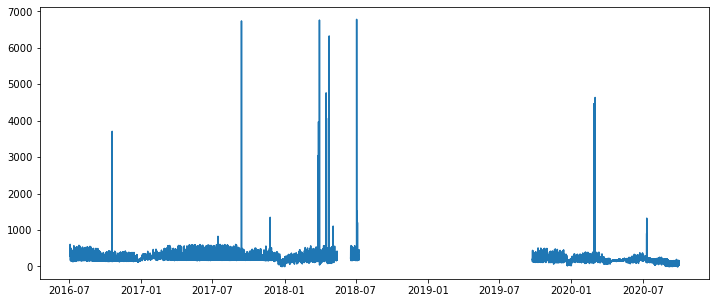

In [56]:
from matplotlib.pyplot import figure
plt.figure(figsize=(12, 5))
plt.plot(df_building0.index, df_building0);

In [57]:
# df_building0['Building0'].astype(float)
# df_building0.plot()

In [58]:
a = df_building0['Building0'].unique()
for i in a:
    print(i)

283.8
606.0
306.0
317.8
300.8
294.3
302.0
309.5
294.8
292.0
297.3
348.0
421.3
473.5
458.0
444.3
289.5
164.3
162.3
164.5
170.8
251.0
284.3
312.0
309.8
307.3
303.3
298.3
290.5
287.8
284.5
277.0
288.3
380.8
460.8
506.3
455.0
376.5
196.0
156.8
155.3
154.3
153.0
237.5
267.0
291.5
290.8
291.3
290.3
289.8
284.8
283.3
296.8
325.8
347.5
418.5
401.0
391.0
302.8
167.5
163.8
160.3
158.8
229.5
260.3
293.3
281.3
283.5
289.0
291.0
297.0
357.0
430.0
422.3
413.3
406.5
240.3
158.0
162.5
241.0
272.3
291.8
300.3
287.3
285.5
278.5
276.0
279.0
276.3
288.8
328.8
346.0
331.0
312.8
295.5
247.8
159.5
160.5
157.0
158.5
211.8
239.0
233.3
234.0
272.8
277.5
275.8
282.8
274.8
278.0
286.5
338.0
390.5
346.3
255.3
226.0
180.0
169.3
156.0
157.5
154.5
155.5
155.0
215.5
236.3
230.8
225.8
246.0
296.0
273.0
275.0
257.0
258.8
295.0
355.3
350.0
280.5
222.3
147.5
139.5
130.8
132.0
132.3
129.5
135.3
217.8
252.0
286.3
288.0
270.5
264.8
262.5
265.0
267.5
263.0
303.5
333.0
341.0
313.0
297.5
250.0
155.8
156.3
161.3
241.3
285.0
277.

In [59]:
df_building0.dtypes

Building0    float64
dtype: object

In [60]:
df_building0.isnull().values.any()

True

### Solar / Building 2 & 3 Analysis

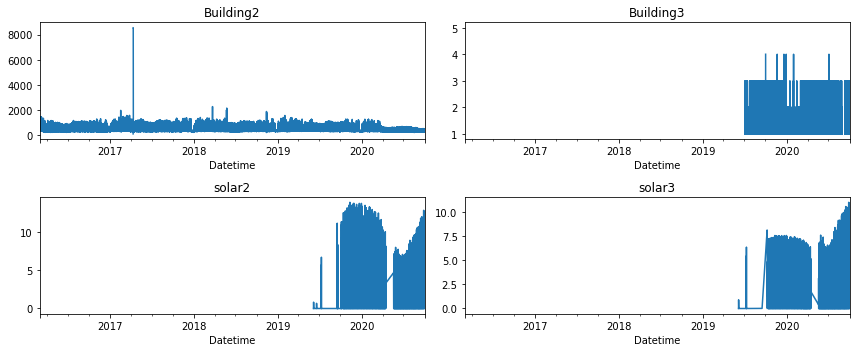

In [61]:
# Graphing the data for the building / solar 2 and 3
plt.subplot(2, 2, 1)
finished_data['Building3'].plot()
plt.title('Building2')

plt.subplot(2, 2, 2)
finished_data['Building4'].plot()
plt.title('Building3')

plt.subplot(2, 2, 3)
finished_data['solar2'].plot(figsize = (12,5))
plt.title('solar2')

plt.subplot(2, 2, 4)
finished_data['solar3'].plot(figsize = (12,5))
plt.title('solar3')

plt.tight_layout()

- Building 2 has the most data, stretching from 2016 while the rest start at around mid 2019
- Building 2 has a day that spiked extremely high and did not repeat in the other years. Must be an outlier as it most likely was not a holiday
- Building 3 has a pretty constant energy usage.
- The solar panels are extremely similar but there are huge amounts of 0 observations

In [62]:
# Check if there's missing values
print(df_building3.isnull().values.any())
print(df_building4.isnull().values.any())
print(df_solar2.isnull().values.any())
print(df_solar3.isnull().values.any())

True
True
False
False


In [63]:
# # Removing the time periods when there is an observation of 0 in the solar data as they were most likely inactive 
# def removing_empty_days(data):
#     empty_dates = []
#     daily_data = data.resample('D').sum()
#     daily_data['Date_time'] = daily_data.index.strftime("%Y-%m-%d")
#     for i in range(len(daily_data)):
#         val, date_value = daily_data.iloc[i]
#         if val < 4:
#             empty_dates.append(str(date_value))
    
#     data['Date_time'] = data.index
#     data['date'] = pd.to_datetime(data['Date_time']).dt.to_period('D')
#     data['date'].dt.strftime('%Y-%m-%d')
#     for j in empty_dates:
#         data = data.drop(data[data['date'] == j].index)

#     data = data.reset_index()
#     data.drop(columns=['Date_time', 'date'], axis = 1, inplace = True)
#     return data


In [64]:
# clean_solar3 = removing_empty_days(df_solar3).set_index('Datetime')
# clean_solar2 = removing_empty_days(df_solar2).set_index('Datetime')

In [65]:
# clean_solar3

In [66]:
# clean_solar3.plot()
# plt.show()
# clean_solar2.plot()
# plt.show()

In [67]:
clean_solar2 = df_solar2[df_solar2['solar2'].map(df_solar2['solar2'].value_counts()).le(97)]
clean_solar3 = df_solar3[df_solar3['solar3'].map(df_solar3['solar3'].value_counts()).le(97)]

### Combining weather and building data

In [68]:
solardata = pd.merge(clean_solar3, clean_solar2, left_index=True, right_index=True, how='inner')
solardata.shape

(19056, 2)

In [69]:
Whether_data=pd.read_csv("/Users/shadi/Downloads/ADS2002 Sem 2/Project/ERA5_Weather_Data_Monash.csv")
nw = Whether_data[54028:94225]

nw['Date'] = pd.to_datetime(nw['datetime (UTC)'])
nw.set_index('Date', inplace=True)
weatherdata = nw.resample('15T').asfreq()
Weather_data = weatherdata.interpolate()
Weather_data

<ipython-input-69-00d4517f52f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nw['Date'] = pd.to_datetime(nw['datetime (UTC)'])


,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
Date,,,,,,,,,,,,,
2016-03-01 04:00:00,2016-03-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,30.730,11.4900,3.8300,101461.2600,0.310,884.1500,358.8400,0.9700
2016-03-01 04:15:00,NaN,NaN,NaN,69.59,10.0,30.795,11.2975,3.6375,101441.4375,0.305,856.8575,360.3900,0.9675
2016-03-01 04:30:00,NaN,NaN,NaN,69.59,10.0,30.860,11.1050,3.4450,101421.6150,0.300,829.5650,361.9400,0.9650
2016-03-01 04:45:00,NaN,NaN,NaN,69.59,10.0,30.925,10.9125,3.2525,101401.7925,0.295,802.2725,363.4900,0.9625
2016-03-01 05:00:00,2016-03-01 05:00:00,"(-37.91, 145.13)",era5,69.59,10.0,30.990,10.7200,3.0600,101381.9700,0.290,774.9800,365.0400,0.9600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 23:00:00,2020-09-30 23:00:00,"(-37.91, 145.13)",era5,69.59,10.0,12.060,6.8000,5.1000,101692.5000,0.700,406.3800,282.6900,0.3500
2020-09-30 23:15:00,NaN,NaN,NaN,69.59,10.0,12.275,6.6775,5.0475,101699.9525,0.685,444.8525,282.1825,0.3825
2020-09-30 23:30:00,NaN,NaN,NaN,69.59,10.0,12.490,6.5550,4.9950,101707.4050,0.670,483.3250,281.6750,0.4150


In [70]:
final = pd.merge(Weather_data, solardata, left_index=True, right_index=True, how='outer')
final = final.drop(['datetime (UTC)', 'coordinates (lat,lon)', 'model (name)', 'utc_offset (hrs)', 'model elevation (surface)'], axis=1)
final = final[123632:160784]
final['hour']=final.index.strftime('%H')
final['day']=final.hour.apply(lambda x: 1 if x >= '07' and x<='18' else 0)
final.shape


(37152, 12)

In [71]:
final_clean = final.dropna()
final_clean.shape

(18994, 12)

In [72]:
final_clean

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1),solar3,solar2,hour,day
2019-09-16 04:00:00,10.9900,3.1200,6.0700,102189.0100,0.580,581.5800,293.8800,0.9800,0.05,3.95,04,0
2019-09-16 04:15:00,10.8900,3.0000,6.0200,102200.3225,0.580,571.6975,291.6925,0.9700,0.05,3.62,04,0
2019-09-16 04:30:00,10.7900,2.8800,5.9700,102211.6350,0.580,561.8150,289.5050,0.9600,0.05,3.29,04,0
2019-09-16 04:45:00,10.6900,2.7600,5.9200,102222.9475,0.580,551.9325,287.3175,0.9500,0.06,2.96,04,0
2019-09-16 05:00:00,10.5900,2.6400,5.8700,102234.2600,0.580,542.0500,285.1300,0.9400,0.06,2.63,05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 22:45:00,11.8025,6.8275,5.0100,101674.3875,0.715,367.3475,282.5450,0.3100,5.49,6.34,22,0
2020-09-30 23:00:00,12.0600,6.8000,5.1000,101692.5000,0.700,406.3800,282.6900,0.3500,5.65,6.39,23,0
2020-09-30 23:15:00,12.2750,6.6775,5.0475,101699.9525,0.685,444.8525,282.1825,0.3825,6.83,7.71,23,0
2020-09-30 23:30:00,12.4900,6.5550,4.9950,101707.4050,0.670,483.3250,281.6750,0.4150,8.02,9.03,23,0


### Building modelling

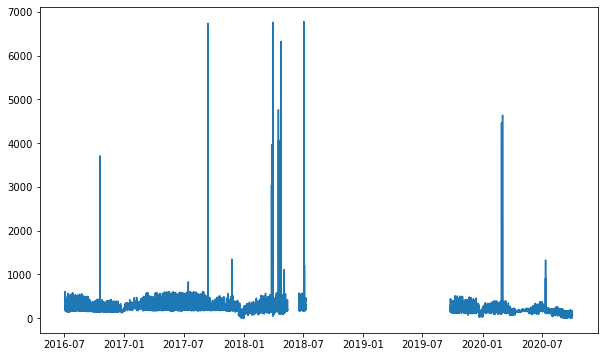

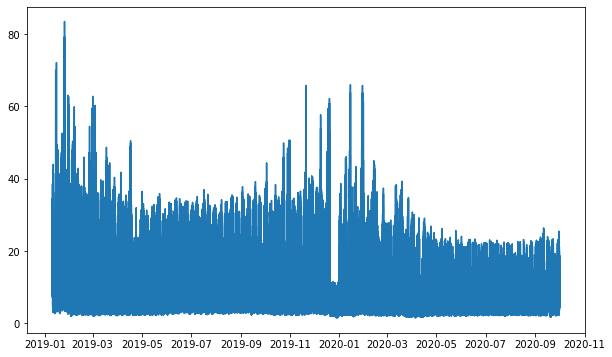

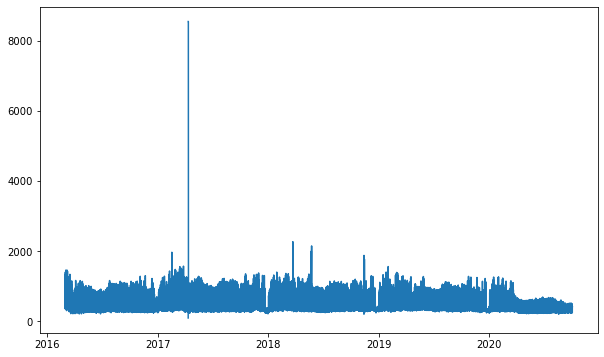

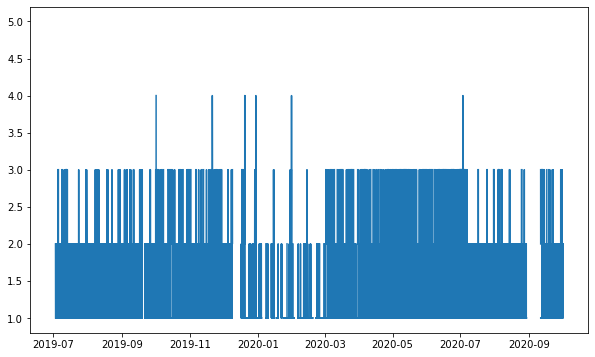

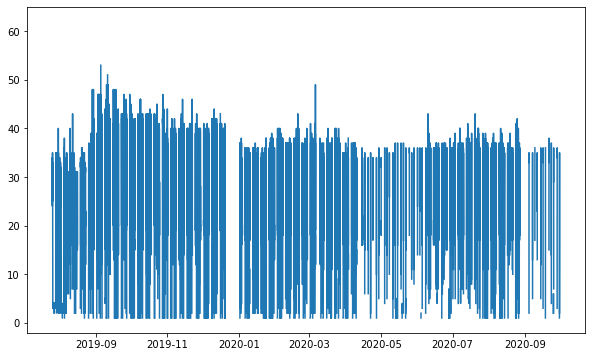

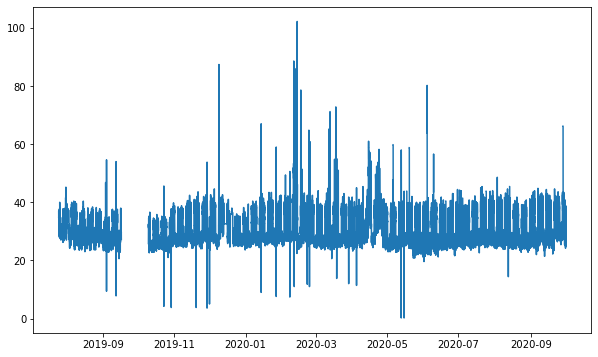

In [73]:
# Last check at each dataset
# Each building has missing data, especially building0
def plot_building(dataframe, row_col_name):
    plt.rcParams["figure.figsize"] = (10,6)
    plt.plot(dataframe.index, dataframe[row_col_name])
    plt.show()    

plot_building(df_building0, 'Building0')
plot_building(df_building1, 'Building1')
plot_building(df_building3, 'Building3')
plot_building(df_building4, 'Building4')
plot_building(df_building5, 'Building5')
plot_building(df_building6, 'Building6')


In [74]:
# Finding how much is missing
print(df_building0.isnull().sum())
print(df_building1.isnull().sum())
print(df_building3.isnull().sum())
print(df_building4.isnull().sum())
print(df_building5.isnull().sum())
print(df_building6.isnull().sum())

Building0    47404
dtype: int64
Building1    88
dtype: int64
Building3    561
dtype: int64
Building4    17661
dtype: int64
Building5    29992
dtype: int64
Building6    2255
dtype: int64


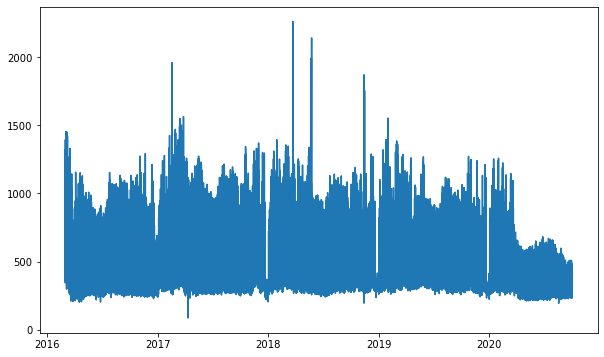

False


In [75]:
# Need to clean the datasets
# Building 0 is very irregular and Building3 has an outlier

# Removing outlier in Building3 
clean_df_building3 = df_building3.loc[df_building3['Building3'] <7000]
plot_building(clean_df_building3, 'Building3')
clean_building_3 = nan_string_convert(clean_df_building3)
print(clean_building_3.isnull().values.any())

In [76]:
# Removing the Nan values as the trend should be weekly, and we have many weeks worth of data
clean_building0 = df_building0.dropna()
clean_building1 = df_building1.dropna()
clean_building3 = clean_building_3.dropna()
clean_building4 = df_building4.dropna()
clean_building5 = df_building5.dropna()
clean_building6 = df_building6.dropna()

In [48]:
# Checking how many values are over 2000 for Building0
outlier_building0 = clean_building0[clean_building0['Building0'] > 2000]
print(outlier_building0.shape)
print(clean_building0.shape)

(44, 1)
(101406, 1)


There are 44 outliers that are over 2000 compared to the 101406 observations so we are going to remove them to prevent the model from learning and predicting these outliers when they happen so rarely.

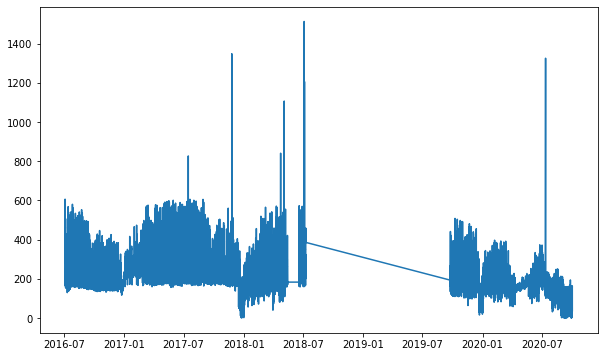

In [49]:
# Building0 without the outliers
final_clean_building0 = clean_building0[clean_building0['Building0'] < 2000]
plot_building(final_clean_building0, 'Building0')

In [50]:
# Checking whether there is a trend in the weekly time frame for the buildings
final_clean_building0["day"] = final_clean_building0.index.day_name() 
mon_building0 = final_clean_building0.loc[final_clean_building0['day'] == 'Monday']
mon_building0_fin = mon_building0.groupby(mon_building0.index.hour).mean()


tues_building0 = final_clean_building0[final_clean_building0['day'] == 'Sunday']
tues_building0_fin = tues_building0.groupby(tues_building0.index.hour).mean()



<ipython-input-50-8a42fc98e528>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_clean_building0["day"] = final_clean_building0.index.day_name()


### Problems so far
- Predicting 15 minute intervals makes the model susceptilbe to extreme outerliers, learns a lot of noise.
- Not a lot of models can be used to predict such small intervals
- There is too much missing data in the buildings to construct easy training and testing sets
- The models are too advanced, need to read into more.
- There is only time to predict. 

Can use phase 2 of the dataset to be the training set
Need to explore phase 2


### Modelling

In [51]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
from pmdarima.arima import auto_arima


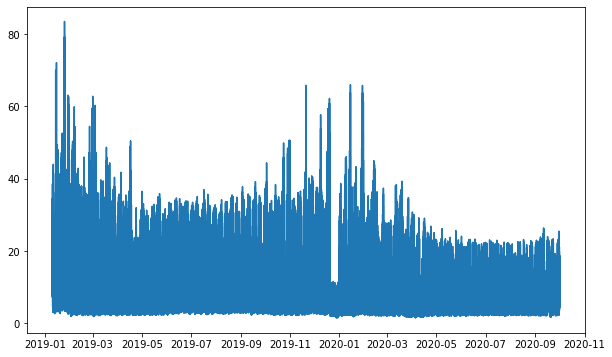

In [52]:
# Just experimenting with building1
plot_building(clean_building1, 'Building1')

Trendwise, there is a decrease overtime with surges for more power consumption.
Seasonality wise, there is none that can be immediately observed.

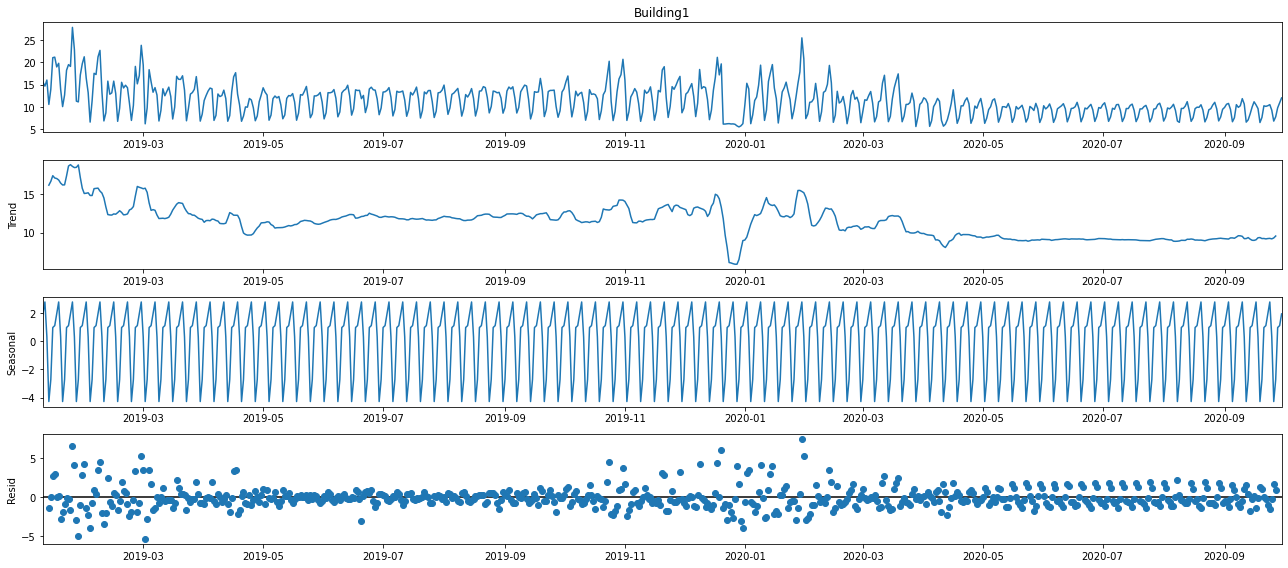

In [53]:
# Checking for trends, seasonality and noise
# Need to resample into days as decompose does not work with missing time periods
building1_hour = clean_building1['Building1'].resample('D').mean()

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(building1_hour, model='additive')
fig = decomposition.plot()
plt.show()

There is a decreasing trend apparent and there is a clear seasonality

In [77]:
# Making training and testing set (just building1)
training = clean_building1[:'2019-09-30']
testing = clean_building1['2019-10']

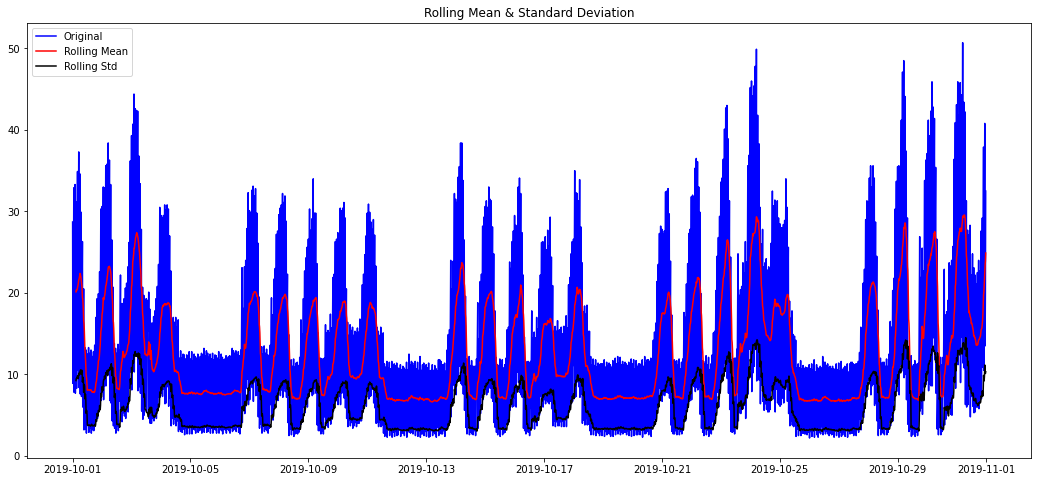

Results of Dickey-Fuller Test:
Test Statistic                -8.277751e+00
p-value                        4.607234e-13
#Lags Used                     2.800000e+01
Number of Observations Used    2.945000e+03
Critical Value (1%)           -3.432572e+00
Critical Value (5%)           -2.862522e+00
Critical Value (10%)          -2.567293e+00
dtype: float64


In [55]:
# Before doing any modelling, need to make the data stationary
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(testing)

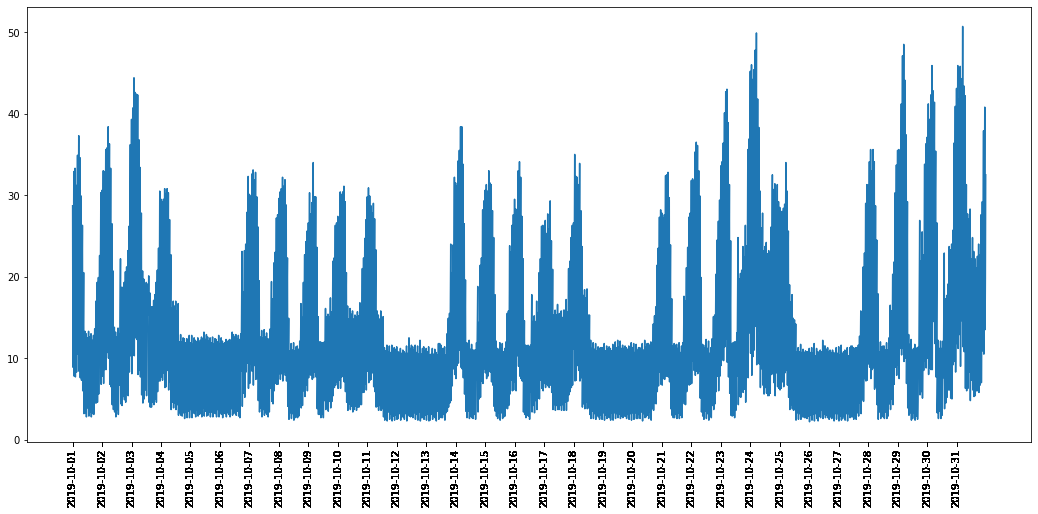

In [56]:
plt.plot(testing)
plt.xticks(testing.index.date, rotation = 90)
plt.show()

There is a weekly seasonality.

Using the Dickey Fuller test to test whether the data is stationary on the training data, the p value is extremely small and so the data is most likely to be stationary. However, while it may be stationary, this test may not be able to detect the stationaryity in this case

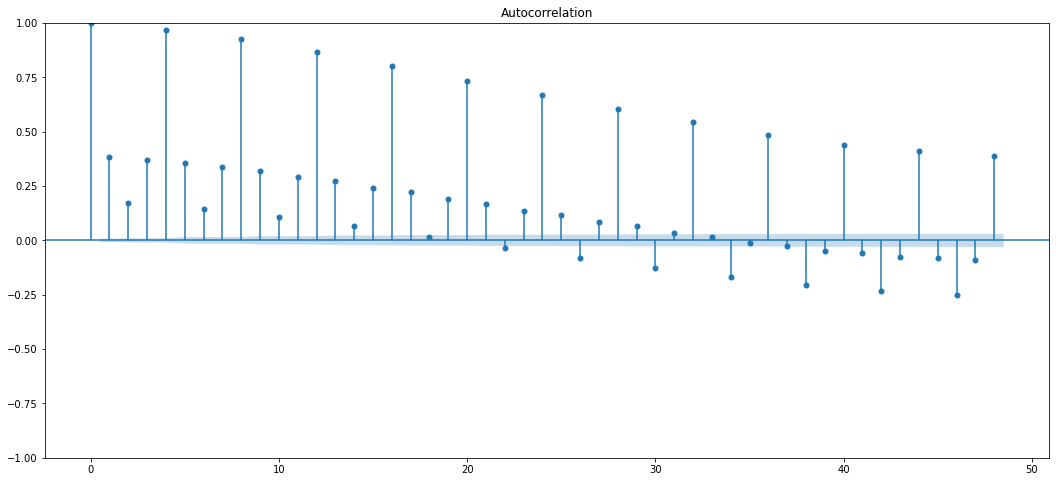

C:\Users\shadi\Downloads\Anaconda Application\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


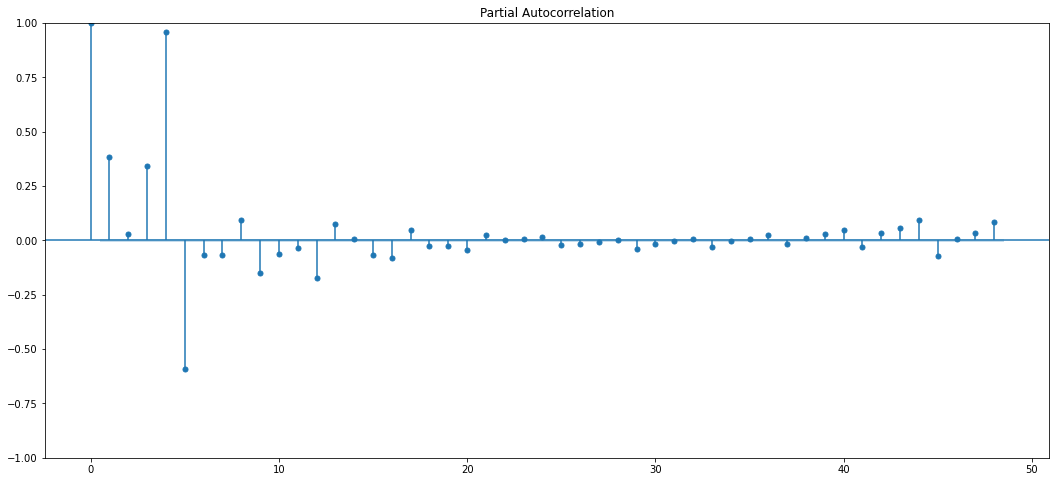

In [60]:
# Visualising parameters for SARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(clean_building1)
matplotlib.pyplot.show()
plot_pacf(clean_building1)
matplotlib.pyplot.show()

Viewing the PACF plot, there is a significant spike at 0, 4 and 5. This gives the potential p value for ARIMA.
Viewing the PCF plot, there is a significant spike at 0 and every interval of 4 afterwards. This gives the potential q value for ARIMA.


In [ ]:
arima_model = auto_arima(training, start_p = 1, start_q = 1, 
                        test = 'adf',
                        max_p = 5,  max_q = 4, 
                        m = 4*24*7,
                        start_P = 0, seasonal = True,
                        error_action = 'ignore',
                        suppress_warnings = True,
                        stepwise = True)

print(arima_model.aic())

In [ ]:
arima_model.fit(training)

In [ ]:
future_forecast = arima_model.predict(n_periods = 2974)

In [ ]:
future_forecast

In [ ]:
future_forecast2 = pd.DataFrame(future_forecast, columns = ['Prediction']).set_index(testing.index)

pd.concat([training, future_forecast2], axis = 1).plot()

We can see that SARIMA does not capture the seasons at all. This is probably due to the use of the wrong seasonal parameter as using a higher degree takes too much memory to run. Going to try and seasonally difference regardless

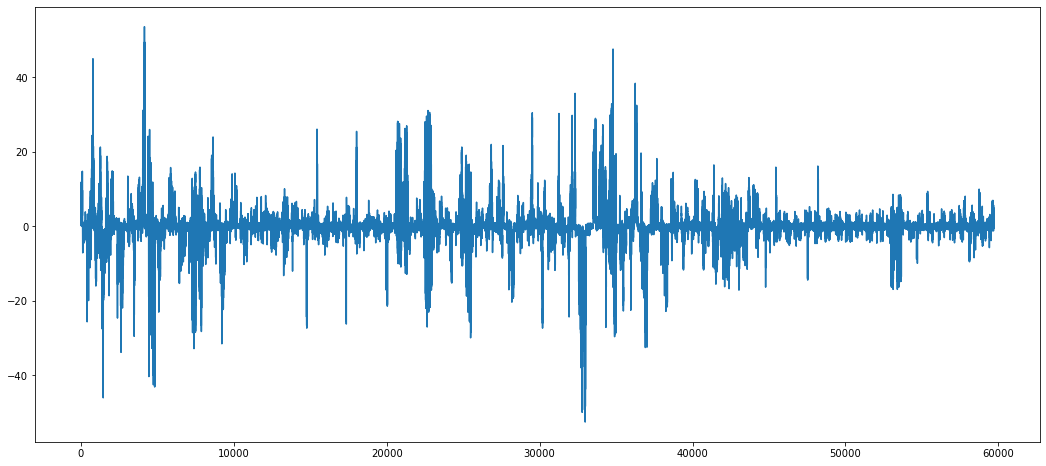

In [57]:
# Making it stationary by subtracting last weeks observations with the current weeks
from matplotlib import pyplot
X = clean_building1.values
diff = list()
days_in_year = 4*24*7
for i in range(days_in_year, len(X)):
    value = X[i] - X[i - days_in_year]
    diff.append(value)
pyplot.plot(diff)
pyplot.show()

In [58]:
# Creating a new training and testing set
building1_stationary = pd.DataFrame(diff)
# training_stationary = diff[:'2019-09-30']
# testing_stationary = diff['2019-10']
building1_stationary

,0
0,0.4
1,3.9
2,7.0
3,6.1
4,3.1
...,...
59718,0.4
59719,0.3
59720,-0.5
59721,0.1


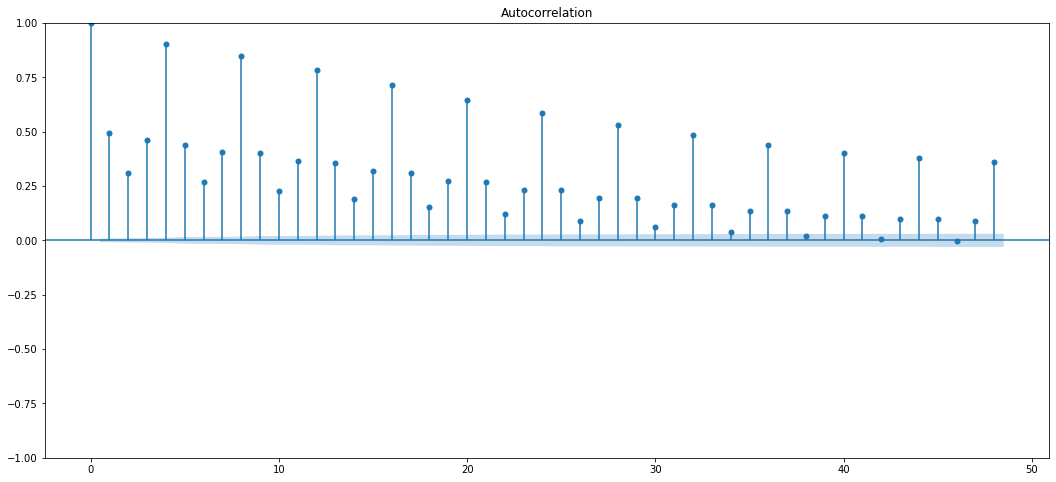

C:\Users\shadi\Downloads\Anaconda Application\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


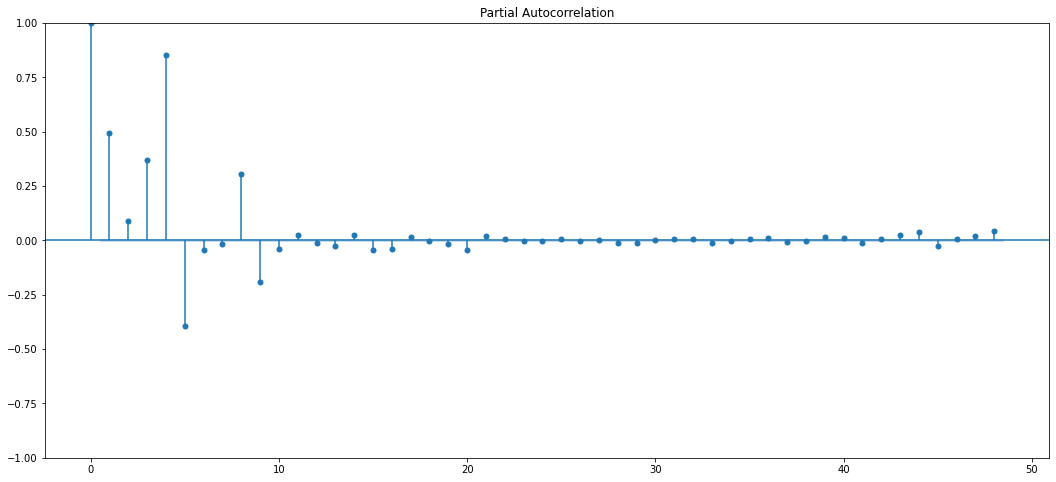

In [61]:
plot_acf(building1_stationary)
matplotlib.pyplot.show()
plot_pacf(building1_stationary)
matplotlib.pyplot.show()

In [90]:
arima_model = auto_arima(building1_stationary,
                         start_p = 0,
                         start_q = 0,
                         max_p = 5,
                         max_q = 4,
                         m = 1,
                         start_P = 0, seasonal = False,
                         error_action = 'ignore',
                         suppress_warnings = True,
                         stepwise = True)

print(arima_model.aic())

234172.0960316274


In [91]:
building1_training = building1_stationary[:-672]
building1_testing = building1_stationary[-672:]

In [92]:
arima_model.fit(building1_training)

ARIMA(order=(5, 0, 4), scoring_args={}, suppress_warnings=True)

In [93]:
future_forecast = arima_model.predict(n_periods = 672)

<AxesSubplot:>

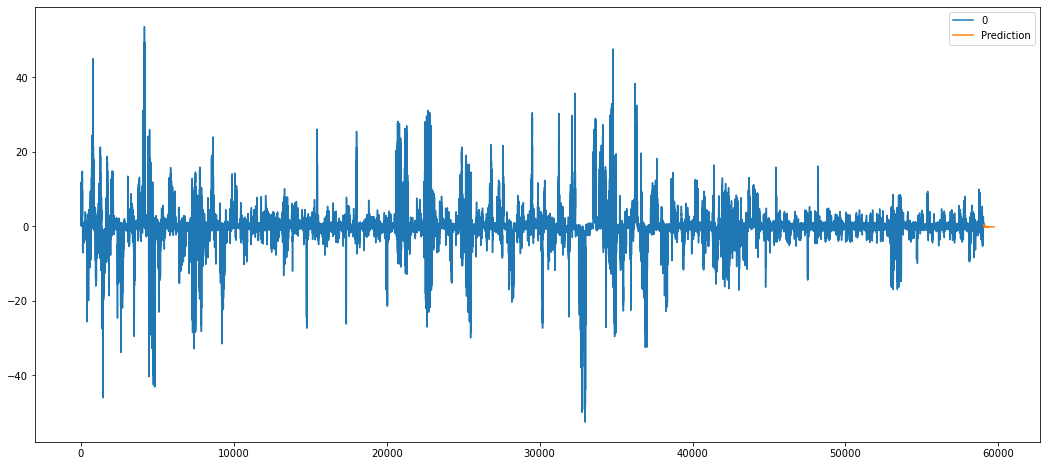

In [94]:
future_forecast2 = pd.DataFrame(future_forecast, columns = ['Prediction']).set_index(building1_testing.index)

pd.concat([building1_training, future_forecast2], axis = 1).plot()

<ipython-input-84-4914dde24175>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing["day"] = testing.index.day_name()


<AxesSubplot:xlabel='Datetime'>

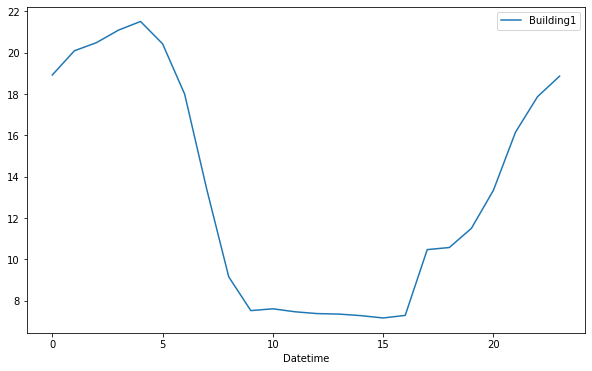

In [84]:
testing["day"] = testing.index.day_name()
mon_solar_data0 = testing.loc[testing['day'] == 'Saturday']
# mon_solar_data0_fin = mon_solar_data0.groupby(mon_solar_data0.index.hour).mean()
mon_solar_data0_fin.plot()
